# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [315]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [316]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Rename the 'id' field to 'offer_id' to not confuse with the customer id in the profile table
portfolio.rename({"id":"offer_id"}, axis=1, inplace=True)
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [317]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [318]:
# Rename the 'id' field to 'cust_id'
profile.rename({"id":"cust_id"}, axis=1, inplace=True)
profile.head()

,gender,age,cust_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [319]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   cust_id           17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [320]:
# Rename 'person' to 'cust_id' to match the profile dataframe
transcript.rename({"person":"cust_id"}, axis=1, inplace=True)
transcript.head()

,cust_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [321]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   cust_id  306534 non-null  object
 1   event    306534 non-null  object
 2   value    306534 non-null  object
 3   time     306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [322]:
print('There are {} unique cust_ids in the transcript table.'.format(transcript.cust_id.nunique()))

There are 17000 unique cust_ids in the transcript table.


In [323]:
# Flatten the 'value' dictionary field into separate columns
flat_dict = pd.json_normalize(transcript.value)
flat_dict['offer_id'] = flat_dict['offer_id'].fillna(flat_dict['offer id'])
flat_dict.drop(['offer id'], axis=1, inplace=True)
transcript = pd.concat([transcript, flat_dict], axis=1)
transcript.drop(['value'], axis=1, inplace=True)
transcript.head()

,cust_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [324]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cust_id   306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   amount    138953 non-null  float64
 4   offer_id  167581 non-null  object 
 5   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [325]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [326]:
# Examine the event history for a single example customer
mask = transcript.cust_id == '78afa995795e4d85b5d9ceeca43f5fef'
transcript.loc[mask,:]

,cust_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN


# Transcript Notes

## Event Order

There are several ways the order of events may unfold:

1. Transaction (NOT influenced by offer)
2. Offer Received, Transaction, Order Completed (NOT influenced by offer since they didn't view it)
3. Offer Received, Offer Viewed, Offer Expires (NOT influenced by offer)
4. Offer Received, Offer Expires (NOT influenced by offer)
5. Offer Received, Transaction, Order Completed, Order Viewed (NOT influenced by offer)
6. Offer Received, Transaction, Order Completed (NOT influenced by offer)
7. Offer Received, Offer Viewed, Transaction, Offer Completed (influenced by offer)
8. Offer Received, Offer Viewed, Transaction within Informational offer duration (influenced by offer)

It seems that if we want to figure out who is influenced by an offer that we need a flag indicating if sequence of events #7 or #8 above occurred for each offer received. We should also record the total amount of offer and non-offer spend a each customer has.


## Identify People Who Would Have Bought Anyway
We also need to try to identify the demographics of customers who seem to buy regardless of offers received so that they may be excluded from the offer campaigns.

# Data Cleaning

Combine transaction, profile, and portfolio data into one dataframe so that we can use it for machine learning.  Transcript data should be reduced to one record per offer, which then has the customer demographics and offer attributes appeneded.

In [327]:
# Flatten the 'channels' column in the portfolio dataframe into indicator columns

# From https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: (item in x)).astype(int)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

channels = ['web','email','mobile','social']
portfolio = pd.concat([portfolio, boolean_df(portfolio.channels, channels)], axis=1).drop(['channels'], axis=1)
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [328]:
# Merge portfolio offer data to the transcript table
transcript = transcript.merge(portfolio, on='offer_id', how='left')
transcript.head()

,cust_id,event,time,amount,offer_id,reward_x,reward_y,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [329]:
# Convert member date to number of days from the maximum member date in the data set
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['member_days'] = (profile.became_member_on.max() - profile.became_member_on).dt.days
profile.drop(['became_member_on'], axis=1, inplace=True)

# One-hot encode the 'gender' column
profile = pd.concat([profile[:], pd.get_dummies(profile['gender'], prefix='gender')], axis=1)
# .drop(['gender'], axis=1)

profile.head()

,gender,age,cust_id,income,member_days,gender_F,gender_M,gender_O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,356,0,0,0


In [330]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       14825 non-null  object 
 1   age          17000 non-null  int64  
 2   cust_id      17000 non-null  object 
 3   income       14825 non-null  float64
 4   member_days  17000 non-null  int64  
 5   gender_F     17000 non-null  uint8  
 6   gender_M     17000 non-null  uint8  
 7   gender_O     17000 non-null  uint8  
dtypes: float64(1), int64(2), object(2), uint8(3)
memory usage: 714.0+ KB


In [331]:
# Merge profile data to the transcript table
transcript = transcript.merge(profile, on='cust_id', how='left')

# Drop rows in the profile and transcript dataframes with missing income, gender
profile.dropna(inplace=True)
transcript.dropna(subset = ['income'], inplace=True)

transcript.head()

,cust_id,event,time,amount,offer_id,reward_x,reward_y,difficulty,duration,offer_type,...,email,mobile,social,gender,age,income,member_days,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,...,1.0,1.0,0.0,F,75,100000.0,443,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,...,1.0,1.0,0.0,M,68,70000.0,91,0,1,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,...,1.0,1.0,1.0,M,65,53000.0,167,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,4.0,informational,...,1.0,1.0,0.0,M,58,51000.0,257,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,...,1.0,0.0,0.0,F,61,57000.0,318,1,0,0


### Notes:

1. Focus on 'offer received' events, keep one record for each offer and indicate whether it resulted in a transaction or not.
2. For each transaction, is there an 'offer completed' event with the same timestamp?  This works with BOGO and Discount offers. Is there an 'offer viewed' event for this offer with a timestamp between the 'offer received' and the transaction?
3. For 'informational' offers, are there one or more 'transaction' events after an 'offer viewed' event within the offer duration?

    

In [332]:
cust_debug = ['7afdac3fe5994698bad7cde3e7cf19aa']

offers = []
offer_count = 0

dup_ids = []

for cust_id in profile.cust_id.unique():
# for cust_id in cust_debug:
    
    temp_offer = []
    temp_cnt   = 0

    # Subset dataframe for a single customer id
    mask = transcript.cust_id == cust_id
    cust_df = transcript.loc[mask,:] #.copy()

    # Get rows for all 'offer received' events for the given customer id
    mask = cust_df.event == 'offer received'
    offer_df = cust_df.loc[mask,:] #.copy()

    # Loop through list of offers
    for index, row in offer_df.iterrows():
        
        offer_count += 1
        temp_cnt    += 1

        # BOGO or discount offers
        if row.offer_type in ['bogo','discount']:

            # Check if there is an 'offer completed' event with the same offer id within the offer duration
            df_completed = cust_df.loc[(cust_df.event == 'offer completed') & 
                                       (cust_df.offer_id == row.offer_id) &
                                       (cust_df.time <= row.time + row.duration*24) &
                                       (cust_df.time >= row.time)]

            # If there is an 'offer completed', then check if there is an 'offer viewed'
            if not df_completed.empty:
                
                # Only take the first 'offer completed' event to guard against there being multiple
                # offers with the same offer_id within the same duration period
                df_completed = df_completed.head(1)
                
                # Check if there is an 'offer viewed' event with the same offer_id within the 
                #  offer duration prior to this time
                for index2, row2 in df_completed.iterrows():

                    df_viewed = cust_df.loc[(cust_df.event == 'offer viewed') & 
                                            (cust_df.offer_id == row2.offer_id) &
                                            (row.time <= cust_df.time) & 
                                            (cust_df.time <= row2.time)]

                    # If the offer has been viewed before being completed then count this as a successful offer
                    if not df_viewed.empty:

                        # Find the associated transaction amount and put into the 'amount' column of row
                        df_trans = cust_df.loc[(cust_df.event == 'transaction') & 
                                               (cust_df.time == row2.time)]
                        tmprow = row2.values.flatten().tolist()
                        tmprow[3] = df_trans.iloc[0, 3]

                        # Add this to the list of successful offers
                        offers.append(tmprow)
                        temp_offer.append(tmprow)

                    else:
                        offers.append(row.values.flatten().tolist())
                        temp_offer.append(row.values.flatten().tolist())
                        
            else:
                # Otherwise just append as an offer
                offers.append(row.values.flatten().tolist())
                temp_offer.append(row.values.flatten().tolist())
            

        # Informational offers
        else:
            # Check to see if there are transactions within the duration of the offer
            df_tran = cust_df.loc[(cust_df.event == 'transaction') & 
                                  (row.time <= cust_df.time) &
                                  (cust_df.time <= row.time + row.duration*24)]

            if not df_tran.empty:
                # If there are transactions, check there are no 'offer completed' events with the same times
                total_trans = 0
                for index2, row2 in df_tran.iterrows():
                    df_completed = cust_df.loc[(cust_df.event == 'offer completed') & 
                                               (cust_df.time == row2.time)]
                    
                    # If there is no 'offer completed', check if there is an 'offer viewed'
                    # between the offer time and transaction time with the same offer_id
                    if df_completed.empty:
                        df_viewed = cust_df.loc[(cust_df.event == 'offer viewed') & 
                                            (cust_df.offer_id == row.offer_id) &
                                            (row.time <= cust_df.time) & 
                                            (cust_df.time < row2.time)]
                        
                        # If there is an'offer viewed' event, then add the transaction amount to total
                        if not df_viewed.empty:
                            total_trans += row2.amount

                # If total transactions under this offer are positive, then add as a successful offer
                if total_trans > 0:
                    tmprow = row.values.flatten().tolist()
                    tmprow[1] = 'offer completed'
                    tmprow[3] = total_trans

                    # Add this to the list of successful offers
                    offers.append(tmprow)
                    temp_offer.append(tmprow)

                else:
                    # Otherwise just append as an offer
                    offers.append(row.values.flatten().tolist())
                    temp_offer.append(row.values.flatten().tolist())

            else:
                # Otherwise just append as an offer
                offers.append(row.values.flatten().tolist())
                temp_offer.append(row.values.flatten().tolist())
                
    recs_added = len(temp_offer)
    if temp_cnt != recs_added:
        dup_ids.append(cust_id)
        print(cust_id)

# Convert list of lists into a dataframe
offers_df = pd.DataFrame(offers, columns=transcript.columns)

# Confirm that the number of records in the transcript table with 'offer received' events match
# the number of records in the new offers_df dataframe
if offers_df.shape[0] != transcript.event.value_counts()['offer received']:
    print('offer_count: {}'.format(offers_df.shape[0]))
    print('value_count: {}'.format(transcript.event.value_counts()['offer received']))
    print('Condensed table row count does not match number of offers received!')
#     assert offers_df.shape[0] == transcript.event.value_counts()['offer received']

# Create a binary field to indicate successful offers
offers_df['success'] = 0
mask = offers_df.event == 'offer completed' 
offers_df.loc[mask, 'success'] = 1
offers_df.drop(['event'], axis=1, inplace=True)

offers_df

,cust_id,time,amount,offer_id,reward_x,reward_y,difficulty,duration,offer_type,web,...,mobile,social,gender,age,income,member_days,gender_F,gender_M,gender_O,success
0,0610b486422d4921ae7d2bf64640c50b,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,...,1.0,0.0,F,55,112000.0,376,1,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,504,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,4.0,informational,1.0,...,1.0,0.0,F,55,112000.0,376,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,1.0,...,1.0,0.0,F,75,100000.0,443,1,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,168,49.39,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.0,3.0,informational,0.0,...,1.0,1.0,F,75,100000.0,443,1,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,510,21.72,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,10.0,7.0,bogo,0.0,...,1.0,1.0,F,75,100000.0,443,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,9dc1421481194dcd9400aec7c9ae6366,576,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,7.0,bogo,0.0,...,1.0,1.0,F,83,50000.0,871,1,0,0,0
66497,e4052622e5ba45a8b96b59aba68cf068,54,21.55,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,3.0,7.0,7.0,discount,1.0,...,1.0,1.0,F,62,82000.0,369,1,0,0,1
66498,e4052622e5ba45a8b96b59aba68cf068,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,4.0,informational,1.0,...,1.0,0.0,F,62,82000.0,369,1,0,0,0
66499,e4052622e5ba45a8b96b59aba68cf068,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,1.0,...,1.0,1.0,F,62,82000.0,369,1,0,0,0


In [333]:
# Calculate total offer and non-offer spend for each customer

# Calculate offer spend by customer
offers_compressed = offers_df.groupby(['cust_id','time'])['amount'].mean().to_frame().reset_index()
offer_spend = offers_compressed.groupby('cust_id')['amount'].sum().to_frame().reset_index()
offer_spend.columns = ['cust_id', 'offer_spend']

# Calculate total spend by customer
mask = transcript.event == 'transaction'
transact_df = transcript.loc[mask,:].copy()
total_spend = transact_df.groupby('cust_id')['amount'].sum().to_frame().reset_index()
total_spend.columns = ['cust_id', 'total_spend']

# Merge spend data with the customer table
profile = profile.merge(offer_spend, on='cust_id', how='left')
profile = profile.merge(total_spend, on='cust_id', how='left')

# Calculate non-offer spend and fraction of total spend from offers
profile['non_offer_spend'] = profile.total_spend - profile.offer_spend
profile['frac_offer_spend'] = profile.offer_spend / profile.total_spend

profile.head()

,gender,age,cust_id,income,member_days,gender_F,gender_M,gender_O,offer_spend,total_spend,non_offer_spend,frac_offer_spend
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,1,0,0,0.00,77.01,77.01,0.000000
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0,91.00,159.27,68.27,0.571357
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91,0,1,0,18.42,57.73,39.31,0.319072
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167,0,1,0,36.43,36.43,0.00,1.000000
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,0,1,0,7.14,15.62,8.48,0.457106


# Exploratory Data Analysis
Here we are going to look at the main metrics associated with the customers, namely their age, income, gender, and membership duration.  We will also look at offer and non-offer spend by age, gender, and membership duration.

## Age Distribution

Minimum age: 18
Maximum age: 101


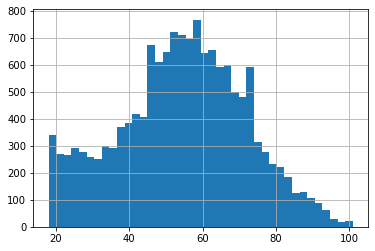

In [334]:
_ = profile.age.hist(bins=40)
print('Minimum age: {}'.format(profile.age.min()))
print('Maximum age: {}'.format(profile.age.max()))

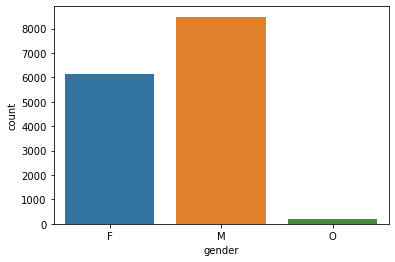

In [335]:
ax = sns.countplot(data=profile, x='gender')

The ages in the dataset range from 18 to 101 years old. It also seems that the customer age skews a bit older with most falling into the 40-65 year range and also skews male. Lets group the ages into range buckets and do some further analysis.

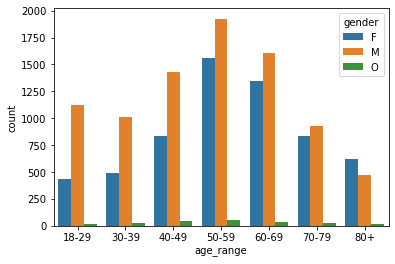

In [336]:
# Create age ranges

# From: https://stackoverflow.com/questions/52753613/grouping-categorising-ages-column-in-python-pandas
ranges = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
lower_bounds = [18, 30, 40, 50, 60, 70, 80, 110]
profile['age_range'] = pd.cut(profile.age, bins = lower_bounds, labels = ranges, right = False)
profile['age_range'] = pd.Categorical(profile.age_range, ordered = True, categories = ranges)

ax = sns.countplot(data=profile, x='age_range', hue='gender')

We see that males are overrepresented in each age range except 80+, which makes sense since females live around 8% longer on average than males.

## Income

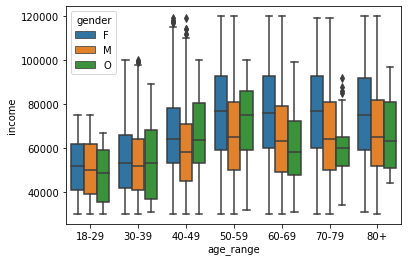

In [337]:
ax = sns.boxplot(data=profile, x='age_range', y='income', hue='gender')

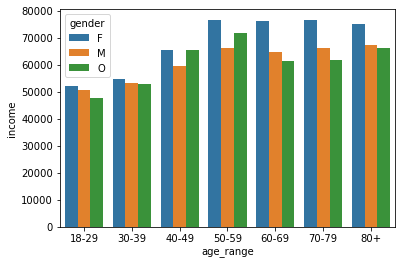

In [338]:
ax = sns.barplot(data=profile, x='age_range', y='income', hue='gender', ci=None)

We see that income rises with age group as expected, although I'm surprised that there is not much of a drop-off in the later age ranges.  We also see that females make more than males in every age group, which is surprising in that it goes against the prevailing narrative.

## Membership Tenure

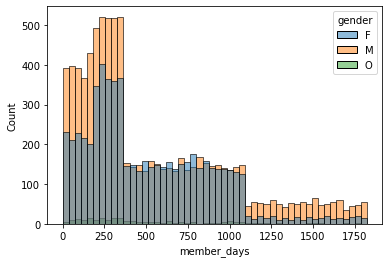

In [339]:
ax = sns.histplot(data=profile, x='member_days', hue='gender', bins=50)

This is a very interesting result, there are prominent break points at around a year and around three years of membership tenure. This suggests that we should group the membership tenure accordingly.

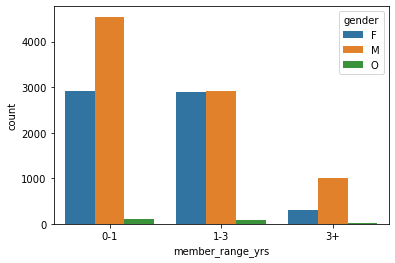

In [340]:
# Create membership tenure ranges
ranges = ['0-1', '1-3', '3+']
lower_bounds = [0, 365, 1095, profile.member_days.max()+1]
profile['member_range_yrs'] = pd.cut(profile.member_days, bins = lower_bounds, labels = ranges, right = False)
profile['member_range_yrs'] = pd.Categorical(profile.member_range_yrs, ordered = True, categories = ranges)

ax = sns.countplot(data=profile, x='member_range_yrs', hue='gender')

Another interesting result, men are overrepresented in short and long membership durations but are equal to women in the 1-3 year range.

## Spend Patterns
Now we look at total, offer, and non-offer spend across different categories.

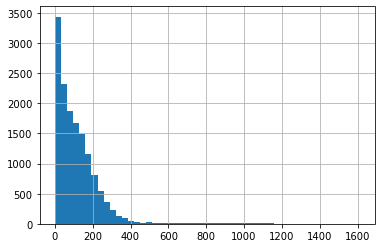

In [341]:
ax = profile.total_spend.hist(bins=50)

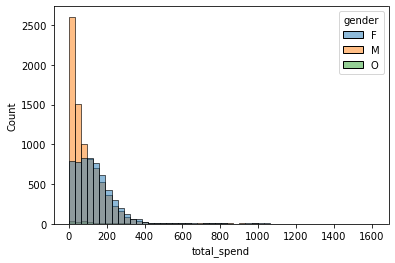

In [342]:
ax = sns.histplot(data=profile, x='total_spend', hue='gender', bins=50)

As would be expected, the distribution of total spend is right-skewed. We also see there is a large contigent of males who don't spend as much.

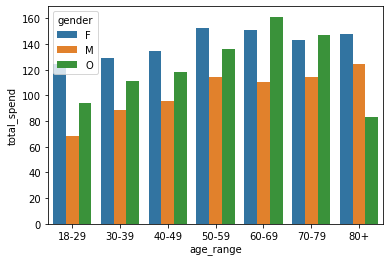

In [343]:
ax = sns.barplot(data=profile, x='age_range', y='total_spend', hue='gender', ci=None)

Females have the highest average spend in every age group, with 'other' coming in second in every age group except 80+.

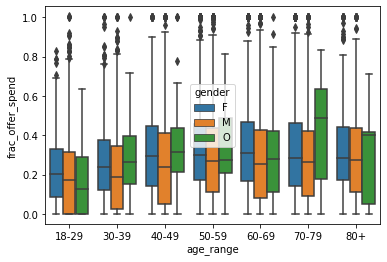

In [344]:
ax = sns.boxplot(data=profile, x='age_range', y='frac_offer_spend', hue='gender')

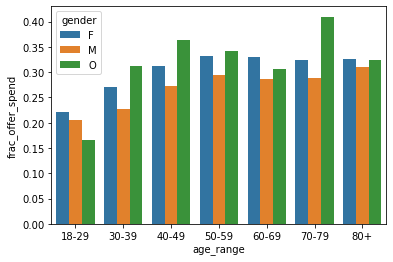

In [345]:
ax = sns.barplot(data=profile, x='age_range', y='frac_offer_spend', hue='gender', ci=None)

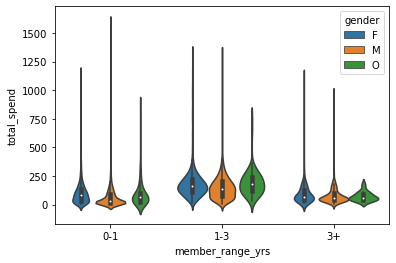

In [346]:
ax = sns.violinplot(data=profile, x='member_range_yrs', y='total_spend', hue='gender')

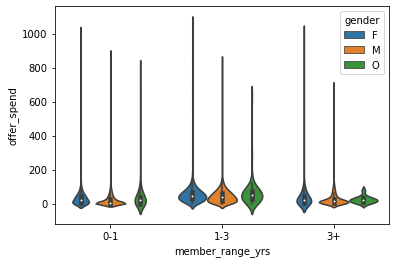

In [347]:
ax = sns.violinplot(data=profile, x='member_range_yrs', y='offer_spend', hue='gender')